In [1]:
import simpy
import numpy as np
from scipy.stats import expon, t
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor
from simpy import PriorityItem
import random
import seaborn as sns

In [2]:
def seed_all(seed=42):
    random.seed(seed)
    np.random.seed(seed)

seed_all()

# Define simulation class, visualization and helper functions 

In [3]:
# Question 4: hyperexponential distribution for service time
def hyperexponential_rvs(mus: np.array, probs: np.array, n: int, random_state: int):
    """
        Generates n samples from a hyperexponential distribution with getting single sample x ~ exp(mus[i]) with probability probs[i].
    """

    choices = np.random.default_rng(random_state).choice(len(mus), size=n, p=probs)
    samples = np.zeros(n)

    for i, mu in enumerate(mus):
        mask = (choices == i)
        samples[mask] = expon.rvs(scale=1/mu, size=np.sum(mask), random_state=random_state)
    
    return samples

In [7]:
env = simpy.Environment()
queue = simpy.PriorityResource(env)

nums = [9,7,5,3,1]
priors = []
for j in nums:
    i=j+1
    priors.append(i)

for j in nums:
    priors.append(j)
print(priors)
priors = np.array(priors)/100

def dummy(i):
    with queue.request(priority=i) as request:
        yield request
        print(i)
        env.timeout(1)

env.process(dummy(10))

for i in priors:
    env.process(dummy(i))

env.run(until=10)  # Run long enough to process all items

# SJF_queue = simpy.PriorityStore(env)

# for i in [9,7,5,3,1]:
#     print(i)
#     SJF_queue.put(PriorityItem(priority=i, item=f'{i}'))

# for j in [9,7,5,3,1]:
#     i=j+1
#     print(i)
#     SJF_queue.put(PriorityItem(priority=i, item=f'{i}'))

# def dummy():
#     item = yield SJF_queue.get()  # Get an item from the queue
#     print(f"Retrieved: {item.item} with priority {item.priority}")

# for i in range(10, -1, -1):
#     env.process(dummy())

# env.run(until=11)  # Run long enough to process all items

[10, 8, 6, 4, 2, 9, 7, 5, 3, 1]
10
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1


In [ ]:
class MMN:
    def __init__(
        self, 
        rho: float, 
        mu: float, 
        num_servers_arr: np.array, 
        T: int, 
        random_state: int,
        SJF: bool = False,
        deterministic_service_time: float = None,
        hyperexp_service_time_params: dict = None
    ):
        """
            rho: the load of the system.
            mu: the capacity of each of the N servers.
            num_servers_arr: an array of different number of servers to run simulation for, 
                i.e. [1,2] denotes simulation is run with the same samples when there are 1 servers and 2 servers.
            T: the time horizon to run the simulation for.
            random_state: random_state used for seeding.
            SJF: If true, shortest job is first scheduled, otherwise, FIFO is used.
            deterministic_service_time: If not None, it is used as the deterministic service time.
            hyperexp_service_time_params: If not None, it is a dictionary containing:
                - 'mus': an array of rate parameters for the exponential distributions.
                - 'probs': an array of probabilities corresponding to each exponential distribution.
        """
    
        self.rho = rho
        self.mu = mu

        # Set the arrival rate self.lamb of the number of jobs into the system.
        if deterministic_service_time:
            self.lamb = rho * (num_servers_arr * deterministic_service_time)
        elif hyperexp_service_time_params:
            if 'mus' not in hyperexp_service_time_params or 'probs' not in hyperexp_service_time_params:
                raise ValueError("hyperexponential_service_time_params must contain 'mus' and 'probs' keys")
            
            self.mus = np.array(hyperexp_service_time_params['mus'])
            self.probs = np.array(hyperexp_service_time_params['probs'])
            self.lamb = rho * (num_servers_arr * (self.mus * self.probs).sum())
        else:
            self.lamb = rho * (num_servers_arr * mu)
    
        self.num_servers_arr = num_servers_arr
        self.T = T
        self.batch_sample_size = np.ceil(self.lamb*self.T*5).astype(int)
        self.num_diff_N = len(num_servers_arr)
        self.SJF = SJF
        self.deterministic_service_time = deterministic_service_time
        self.hyperexp_service_time_params = hyperexp_service_time_params

        # Reproducibility params
        self.random_state_lamb = random_state
        self.random_state_mu = random_state + 1
        self.random_state_jump = 10^4

        # SimPy environment and resources
        self.env_FIFO = simpy.Environment()
        self.env_SJF = simpy.Environment()
        self.servers_diff_N_FIFO = [simpy.Resource(self.env_FIFO, capacity=N) for N in num_servers_arr]
        self.servers_diff_N_SJF = [simpy.PriorityResource(self.env_SJF, capacity=N) for N in num_servers_arr]

        # Statistics
        self.waiting_times_FIFO = [[] for _ in range(self.num_diff_N)]
        self.system_times_FIFO = [[] for _ in range(self.num_diff_N)]
        self.waiting_times_SJF = [[] for _ in range(self.num_diff_N)]
        self.system_times_SJF = [[] for _ in range(self.num_diff_N)]

        # Get initial samples
        self.job_arrival_times_initial = [0]*self.num_diff_N
        self.service_durations_initial= [0]*self.num_diff_N
        for i in range(self.num_diff_N):
            self.job_arrival_times_initial[i], self.service_durations_initial[i] = self.__get_events(i, self.random_state_lamb, self.random_state_mu)

    def __get_events(self, Ns_idx, random_state_lamb, random_state_mu):
        lamb = self.lamb[Ns_idx]
        batch_sample_size = self.batch_sample_size[Ns_idx]
        job_arrival_times = expon.rvs(scale=1/lamb, size=batch_sample_size, random_state=random_state_lamb)
        service_durations = None
                
        # Since service duration is random, we check for whether hyperexponential dist is used for service duration.
        if self.hyperexp_service_time_params:
            service_durations = hyperexponential_rvs(self.mus, self.probs, batch_sample_size, random_state_mu)
        elif self.deterministic_service_time:
            pass
        else:
            service_durations = expon.rvs(scale=1/self.mu, size=batch_sample_size, random_state=random_state_mu)
        
        return job_arrival_times, service_durations

    def __job_arrival_FIFO(self, Ns_idx):
        """Generate job arrivals (FIFO)."""
        job_arrival_times = self.job_arrival_times_initial[Ns_idx]
        service_durations = self.service_durations_initial[Ns_idx]
        i = 0

        # Check if the service duration is random
        if not self.deterministic_service_time:
            while True:
                for job_arrival_time, service_duration in zip(job_arrival_times, service_durations):
                    yield self.env_FIFO.timeout(job_arrival_time)
                    arrival_time = self.env_FIFO.now
                    self.env_FIFO.process(self.__job_process_FIFO(service_duration, Ns_idx, arrival_time))
                
                i+=1
                random_state_lamb = self.random_state_lamb+i*self.random_state_jump
                random_state_mu = self.random_state_mu+i*self.random_state_jump
                job_arrival_times, service_durations = self.__get_events(Ns_idx, random_state_lamb, random_state_mu)
        else:
            while True:
                for job_arrival_time in job_arrival_times:
                    yield self.env_FIFO.timeout(job_arrival_time)
                    arrival_time = self.env_FIFO.now
                    self.env_FIFO.process(self.__job_process_FIFO(self.deterministic_service_time, Ns_idx, arrival_time))
                
                i+=1
                random_state_lamb = self.random_state_lamb+i*self.random_state_jump
                random_state_mu = self.random_state_mu+i*self.random_state_jump
                job_arrival_times, service_durations = self.__get_events(Ns_idx, random_state_lamb, random_state_mu)

    def __job_arrival_SJF(self, Ns_idx):
        """Generate job arrivals (SJF)."""
        job_arrival_times = self.job_arrival_times_initial[Ns_idx]
        service_durations = self.service_durations_initial[Ns_idx]
        i = 0

        # Check if the service duration is random
        if not self.deterministic_service_time:
            while True:
                for job_arrival_time, service_duration in zip(job_arrival_times, service_durations):
                    yield self.env_SJF.timeout(job_arrival_time)
                    arrival_time = self.env_SJF.now
                    self.env_SJF.process(self.__job_process_SJF(service_duration, Ns_idx, arrival_time))
                
                i+=1
                random_state_lamb = self.random_state_lamb+i*self.random_state_jump
                random_state_mu = self.random_state_mu+i*self.random_state_jump
                job_arrival_times, service_durations = self.__get_events(Ns_idx, random_state_lamb, random_state_mu)
        else:
            while True:
                for job_arrival_time in job_arrival_times:
                    yield self.env_SJF.timeout(job_arrival_time)
                    arrival_time = self.env_SJF.now
                    self.env_SJF.process(self.__job_process_SJF(self.deterministic_service_time, Ns_idx, arrival_time))
                
                i+=1
                random_state_lamb = self.random_state_lamb+i*self.random_state_jump
                random_state_mu = self.random_state_mu+i*self.random_state_jump
                job_arrival_times, service_durations = self.__get_events(Ns_idx, random_state_lamb, random_state_mu)
            
    def __job_process_FIFO(self, service_duration, Ns_idx, arrival_time):
        """Process a single job (FIFO)."""
    
        with self.servers_diff_N_FIFO[Ns_idx].request() as request:
            yield request

            self.waiting_times_FIFO[Ns_idx].append(self.env_FIFO.now - arrival_time)

            yield self.env_FIFO.timeout(service_duration)
            
            self.system_times_FIFO[Ns_idx].append(self.env_FIFO.now - arrival_time)
    
    def __job_process_SJF(self, service_duration, Ns_idx, arrival_time):
        """Process a single job (SJF)."""
        with self.servers_diff_N_SJF[Ns_idx].request(priority=service_duration) as request:
            yield request

            self.waiting_times_SJF[Ns_idx].append(self.env_SJF.now - arrival_time)

            yield self.env_SJF.timeout(service_duration)
            
            self.system_times_SJF[Ns_idx].append(self.env_SJF.now - arrival_time)
        
    def run_simulation(self):
        """Run the simulation."""
        # Run the simulation for different N at once consequently for both FIFO and SJF services.
        for Ns_idx in range(self.num_diff_N):
            self.env_FIFO.process(self.__job_arrival_FIFO(Ns_idx))
            self.env_FIFO.run(until=self.T*(Ns_idx+1))
        
        result_FIFO = {
            'avg_waiting_times': [np.mean(wt) for wt in self.waiting_times_FIFO],
            'avg_system_times': [np.mean(st) for st in self.system_times_FIFO],
            'waiting_times': self.waiting_times_FIFO,
            'system_times': self.system_times_FIFO
        }
            
        for Ns_idx in range(self.num_diff_N):
            self.env_SJF.process(self.__job_arrival_SJF(Ns_idx))
            self.env_SJF.run(until=self.T*(Ns_idx+1))

        result_SJF = {
            'avg_waiting_times': [np.mean(wt) for wt in self.waiting_times_SJF],
            'avg_system_times': [np.mean(st) for st in self.system_times_SJF],
            'waiting_times': self.waiting_times_SJF,
            'system_times': self.system_times_SJF
        }

        return result_FIFO, result_SJF

# Test 
# num_servers_arr = np.array([1,2,4])
# rho=0.9
# mu=1
# T=100
# num_runs=10
# deterministic_service_time=None
# hyperexp_service_time_params=None

# queue = MMN(
#     rho=rho,
#     mu=mu,
#     num_servers_arr=np.array(num_servers_arr),
#     T=T,
#     random_state=1,
#     deterministic_service_time=deterministic_service_time,
#     hyperexp_service_time_params=hyperexp_service_time_params
# )

# result_FIFO, result_SJF = queue.run_simulation()

# print(result_FIFO['avg_waiting_times'])
# print(result_SJF['avg_waiting_times'])

[2.628593766515076, 1.6245611607954265, 0.6577383830912883]
[1.2899335422969065, 0.7765009678915343, 0.3644573615151533]


In [153]:
def run_multiple_simulations(
        num_runs, 
        rhos, 
        mu, 
        num_servers_arr, 
        T, 
        random_state_offset=0,
        save_file=None, 
        load_file=None,
        deterministic_service_time=None,
        hyperexp_service_time_params=None
    ):
    """Run multiple simulations and average the results."""

    seed_all()

    num_diff_N = len(num_servers_arr)
    smallest_rho = rhos[0]
    largest_rho = rhos[-1]
    num_rhos = len(rhos)

    results_FIFO = {
        'avg_waiting_times': np.zeros((num_rhos, num_diff_N)),
        'avg_system_times': np.zeros((num_rhos, num_diff_N)),
        'conf_waiting_time_upper': np.zeros((num_rhos, num_diff_N)),
        'conf_waiting_time_lower': np.zeros((num_rhos, num_diff_N)),
        'conf_system_time_upper': np.zeros((num_rhos, num_diff_N)),
        'conf_system_time_lower': np.zeros((num_rhos, num_diff_N)),
        'waiting_times': [[[] for _ in range(num_diff_N)] for _ in range(num_rhos)],
        'system_times': [[[] for _ in range(num_diff_N)] for _ in range(num_rhos)]
    }

    results_SJF = {
        'avg_waiting_times': np.zeros((num_rhos, num_diff_N)),
        'avg_system_times': np.zeros((num_rhos, num_diff_N)),
        'conf_waiting_time_upper': np.zeros((num_rhos, num_diff_N)),
        'conf_waiting_time_lower': np.zeros((num_rhos, num_diff_N)),
        'conf_system_time_upper': np.zeros((num_rhos, num_diff_N)),
        'conf_system_time_lower': np.zeros((num_rhos, num_diff_N)),
        'waiting_times': [[[] for _ in range(num_diff_N)] for _ in range(num_rhos)],
        'system_times': [[[] for _ in range(num_diff_N)] for _ in range(num_rhos)]
    }

    if load_file:
        if deterministic_service_time:
            with open(f'data/rho_{smallest_rho}_to_{largest_rho}_with_num_{num_rhos}_mu_{mu}_T_{T}_num_runs_{num_runs}_SJF_D.npy', 'rb') as f:
                results_SJF = np.load(f)
            with open(f'data/rho_{smallest_rho}_to_{largest_rho}_with_num_{num_rhos}_mu_{mu}_T_{T}_num_runs_{num_runs}_FIFO_D.npy', 'rb') as f:
                results_FIFO = np.load(f)
        elif hyperexp_service_time_params: 
            with open(f'data/rho_{smallest_rho}_to_{largest_rho}_with_num_{num_rhos}_mu_{mu}_T_{T}_num_runs_{num_runs}_SJF_H.npy', 'rb') as f:
                results_SJF = np.load(f)
            with open(f'data/rho_{smallest_rho}_to_{largest_rho}_with_num_{num_rhos}_mu_{mu}_T_{T}_num_runs_{num_runs}_FIFO_H.npy', 'rb') as f:
                results_FIFO = np.load(f)
        else: 
            with open(f'data/rho_{smallest_rho}_to_{largest_rho}_with_num_{num_rhos}_mu_{mu}_T_{T}_num_runs_{num_runs}_SJF_M.npy', 'rb') as f:
                results_SJF = np.load(f)
            with open(f'data/rho_{smallest_rho}_to_{largest_rho}_with_num_{num_rhos}_mu_{mu}_T_{T}_num_runs_{num_runs}_FIFO_M.npy', 'rb') as f:
                results_FIFO = np.load(f)
        
        return results_FIFO, results_SJF

    rho_MC_idxs = [(rho_idx, i) for i in range(num_runs) for rho_idx in range(num_rhos)]

    MMNs = [
        MMN(
            rho=rhos[rho_MC_idx[0]],
            mu=mu,
            num_servers_arr=np.array(num_servers_arr),
            T=T,
            random_state=random_state_offset + rho_MC_idx[1],
            deterministic_service_time=deterministic_service_time,
            hyperexp_service_time_params=hyperexp_service_time_params
        )
        for rho_MC_idx in rho_MC_idxs
    ]

    def run_simulation(idxs):
        rho_idx, mc_idx = idxs
        return MMNs[rho_idx * num_runs + mc_idx].run_simulation()

    results_diff_rhos_runs = None

    # We use random_state to seed parallel programming
    with ThreadPoolExecutor() as ex:
        results_diff_rhos_runs = list(ex.map(run_simulation, rho_MC_idxs))
    
    def process_results(results, sim_res, rho_idx, num_runs, num_servers_arr):
        """Helper function to process results for FIFO or SJF."""
        for key in sim_res:
            if key.startswith('avg_'):
                results[key][rho_idx] += sim_res[key]
            else:
                for N_Idx in range(len(num_servers_arr)):
                    results[key][rho_idx][N_Idx].extend(sim_res[key][N_Idx])

        for key in results:
            if key.startswith('avg_'):
                results[key][rho_idx] /= num_runs
        
        conf_margin_waiting_time = [
            np.std(waiting_times, ddof=1) * t.ppf(0.975, num_runs - 1) / np.sqrt(num_runs)
            for waiting_times in results['waiting_times'][rho_idx]
        ]
        conf_margin_system_time = [
            np.std(system_times, ddof=1) * t.ppf(0.975, num_runs - 1) / np.sqrt(num_runs)
            for system_times in results['system_times'][rho_idx]
        ]

        # Store confidence intervals
        results['conf_waiting_time_upper'][rho_idx] = [
            results['avg_waiting_times'][rho_idx][i] + conf_margin
            for i, conf_margin in enumerate(conf_margin_waiting_time)
        ]
        results['conf_waiting_time_lower'][rho_idx] = [
            results['avg_waiting_times'][rho_idx][i] - conf_margin
            for i, conf_margin in enumerate(conf_margin_waiting_time)
        ]

        results['conf_system_time_upper'][rho_idx] = [
            results['avg_system_times'][rho_idx][i] + conf_margin
            for i, conf_margin in enumerate(conf_margin_system_time)
        ]
        results['conf_system_time_lower'][rho_idx] = [
            results['avg_system_times'][rho_idx][i] - conf_margin
            for i, conf_margin in enumerate(conf_margin_system_time)
        ]

        return results

    for rho_idx in range(num_rhos):
        results_diff_runs = results_diff_rhos_runs[rho_idx*num_runs:(rho_idx+1)*num_runs]
        for sim_res_FIFO, sim_res_SJF in results_diff_runs:
            results_FIFO = process_results(results_FIFO, sim_res_FIFO, rho_idx, num_runs, num_servers_arr)
            results_SJF = process_results(results_SJF, sim_res_SJF, rho_idx, num_runs, num_servers_arr)

    
    if save_file:
        if deterministic_service_time:
            with open(f'data/rho_{smallest_rho}_to_{largest_rho}_with_num_{num_rhos}_mu_{mu}_T_{T}_num_runs_{num_runs}_FIFO_D.npy', 'wb') as f:
                np.save(f, results_FIFO)
            with open(f'data/rho_{smallest_rho}_to_{largest_rho}_with_num_{num_rhos}_mu_{mu}_T_{T}_num_runs_{num_runs}_SJF_D.npy', 'wb') as f:
                np.save(f, results_SJF)
        elif hyperexp_service_time_params: 
            with open(f'data/rho_{smallest_rho}_to_{largest_rho}_with_num_{num_rhos}_mu_{mu}_T_{T}_num_runs_{num_runs}_FIFO_H.npy', 'wb') as f:
                np.save(f, results_FIFO)
            with open(f'data/rho_{smallest_rho}_to_{largest_rho}_with_num_{num_rhos}_mu_{mu}_T_{T}_num_runs_{num_runs}_SJF_H.npy', 'wb') as f:
                np.save(f, results_SJF)
        else: 
            with open(f'data/rho_{smallest_rho}_to_{largest_rho}_with_num_{num_rhos}_mu_{mu}_T_{T}_num_runs_{num_runs}_FIFO_M.npy', 'wb') as f:
                np.save(f, results_FIFO)
            with open(f'data/rho_{smallest_rho}_to_{largest_rho}_with_num_{num_rhos}_mu_{mu}_T_{T}_num_runs_{num_runs}_SJF_M.npy', 'wb') as f:
                np.save(f, results_SJF)
            
    return results_FIFO, results_SJF

In [156]:
def format_list(lst):
    return '[' + ', '.join(f'{x:.2f}' if isinstance(x, float) else str(x) for x in lst) + ']'

def plot_statistics(
        results, 
        num_servers_arr, 
        rho, 
        mu, 
        T, 
        num_runs, 
        n_bins=50, 
        edge_color=None, 
        edge_width=0.1, 
        SJF=False, 
        deterministic_service_time=None, 
        hyperexp_service_time_params=None
    ):

    mode = 'FIFO'
    num_col = 2
    mu_str = f'mu = {mu}'
    
    if SJF:
        mode = 'SJF'

    if deterministic_service_time:
        mu_str = f'mu = {deterministic_service_time}'
        mode += ', MDN'
    else:
        mode += ', MMN'

    if hyperexp_service_time_params:
        if 'mus' not in hyperexp_service_time_params or 'probs' not in hyperexp_service_time_params:
            raise ValueError("hyperexponential_service_time_params must contain 'mus' and 'probs' keys")
        
        mus = np.array(hyperexp_service_time_params['mus'])
        probs = np.array(hyperexp_service_time_params['probs'])

        mode += ', hyperexp service'
        mu_str = f'mus = {format_list(mus)} with probs = {format_list(probs)}'


    print(f'Average Waiting Times ({mode}):', [f'{waiting_time:.2f}' for waiting_time in results['avg_waiting_times']])
    print(f'Average System Times ({mode}):', [f'{system_time:.2f}' for system_time in results['avg_system_times']])

    fig, axs = plt.subplots(num_col, 1, figsize=(10, 15))

    # Waiting Time Plot
    for i in range(len(num_servers_arr)):
        axs[0].hist(results['waiting_times'][i], bins=n_bins, edgecolor=edge_color, alpha=0.5, label=f'Servers: {num_servers_arr[i]}', linewidth=edge_width)
    axs[0].set_title(f'Distribution of Waiting Times ({mode})\n(rho={rho}, {mu_str}, T={T}, runs={num_runs})')
    axs[0].set_xlabel('Waiting Time')
    axs[0].set_ylabel('Frequency')
    axs[0].legend()

    # System Time Plot
    for i in range(len(num_servers_arr)):
        axs[1].hist(results['system_times'][i], bins=n_bins, edgecolor=edge_color, alpha=0.5, label=f'Servers: {num_servers_arr[i]}', linewidth=edge_width)
    axs[1].set_title(f'Distribution of System Times ({mode})\n(rho={rho}, {mu_str}, T={T}, runs={num_runs})')
    axs[1].set_xlabel('System Time')
    axs[1].set_ylabel('Frequency')
    axs[1].legend()

    plt.tight_layout()
    plt.show()

def sns_lineplot(rhos, results, axs, num_servers_arr, j, service_type='FIFO', color = 'blue'): 
    # Plot average waiting time with confidence intervals
    sns.lineplot(x=rhos, y=results['avg_waiting_times'][:, j], ax=axs[0], label=f'{num_servers_arr[j]}', marker='o', color=color)

    # Fill between for confidence intervals of waiting times
    axs[0].fill_between(
        rhos,
        results['conf_waiting_time_lower'][:, j],
        results['conf_waiting_time_upper'][:, j],
        color=color, 
        alpha=0.2
    )

    axs[0].plot(rhos, results['conf_waiting_time_lower'][:, j], color=color, linestyle='--', linewidth=1.5)
    axs[0].plot(rhos, results['conf_waiting_time_upper'][:, j], color=color, linestyle='--', linewidth=1.5)

    # Plot average system time with confidence intervals
    sns.lineplot(x=rhos, y=results['avg_system_times'][:, j], ax=axs[1], label=f'{num_servers_arr[j]}', marker='o', color=color)
    axs[1].fill_between(
        rhos, 
        results['conf_system_time_lower'][:, j], 
        results['conf_system_time_upper'][:, j], 
        color=color,
        alpha=0.2
    )

    axs[1].plot(rhos, results['conf_system_time_lower'][:, j], color=color, linestyle='--', linewidth=1.5)
    axs[1].plot(rhos, results['conf_system_time_upper'][:, j], color=color, linestyle='--', linewidth=1.5)

    # Set legends for each subplot
    axs[0].legend(title='Number of Servers', fontsize=12)
    axs[1].legend(title='Number of Servers', fontsize=12)

    axs[0].set_xlabel(r'$\rho$', fontsize=14)
    axs[0].set_ylabel(f'Mean Waiting Time ({service_type})', fontsize=14) 
    axs[1].set_xlabel(r'$\rho$', fontsize=14)
    axs[1].set_ylabel(f'Mean System Time ({service_type})', fontsize=14)

def plot_rho_against_stat(
    results_FIFO,
    results_SJF, 
    num_servers_arr, 
    rhos
):
    num_diff_N = len(num_servers_arr)    
    _, axs = plt.subplots(2, 2, figsize=(15, 10), dpi=300)
    colors = ['blue', 'green', 'orange']

    for j in range(num_diff_N):
        sns_lineplot(rhos, results_FIFO, axs[:, 0], num_servers_arr, j, color=colors[j])
        sns_lineplot(rhos, results_SJF, axs[:, 1], num_servers_arr, j, 'SJF', color=colors[j])

    plt.tight_layout()
    plt.show()

# Question 2 and 3

In [ ]:
num_servers_arr = np.array([1,2,4])
rhos=np.linspace(2,2,1)
mu=1
T=1000
num_runs=10

results_FIFO, results_SJF = run_multiple_simulations(num_runs=num_runs, rhos=rhos, mu=mu, num_servers_arr=np.array(num_servers_arr), T=T)

In [151]:
results_FIFO['avg_waiting_times']

array([[83.7266594 , 55.7892705 , 27.87807324]])

In [152]:
results_SJF['avg_waiting_times']

array([[83.7266594 , 55.7892705 , 27.87807324]])

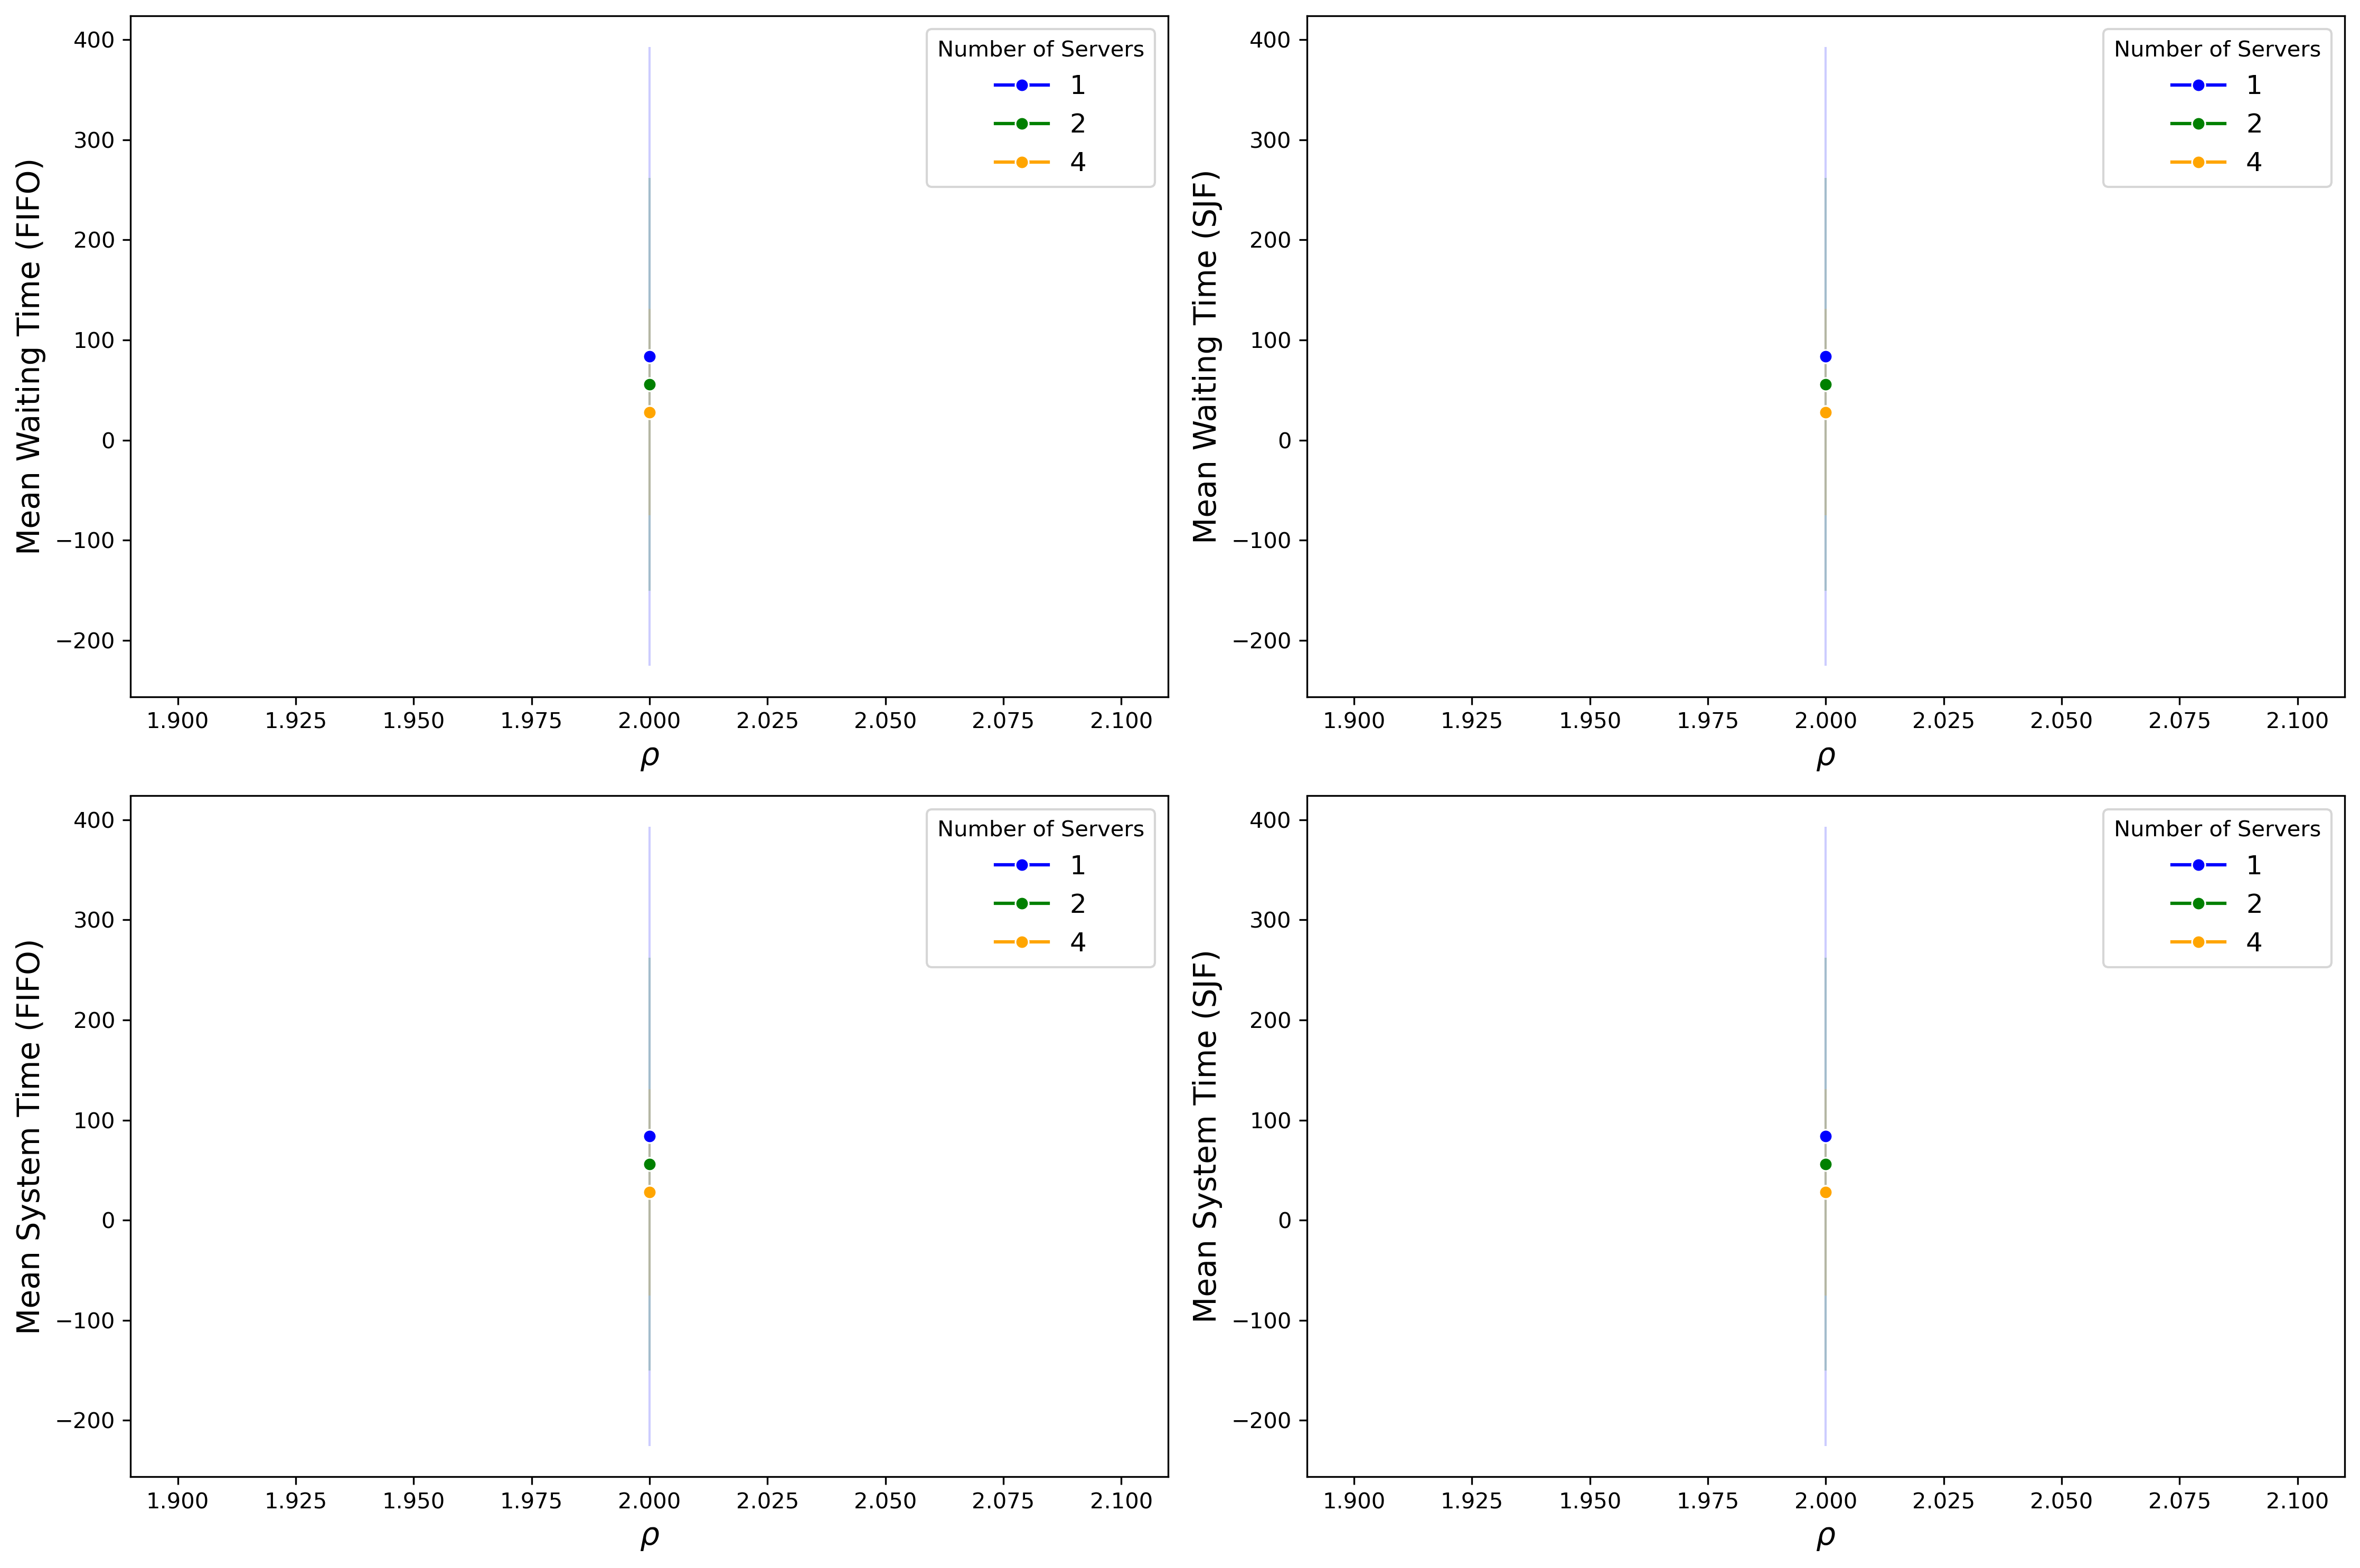

In [157]:
plot_rho_against_stat(results_FIFO, results_SJF, num_servers_arr, rhos)

0.1
Average Waiting Times (FIFO, MMN): ['4.37', '1.90', '0.83']
Average System Times (FIFO, MMN): ['5.36', '2.90', '1.82']


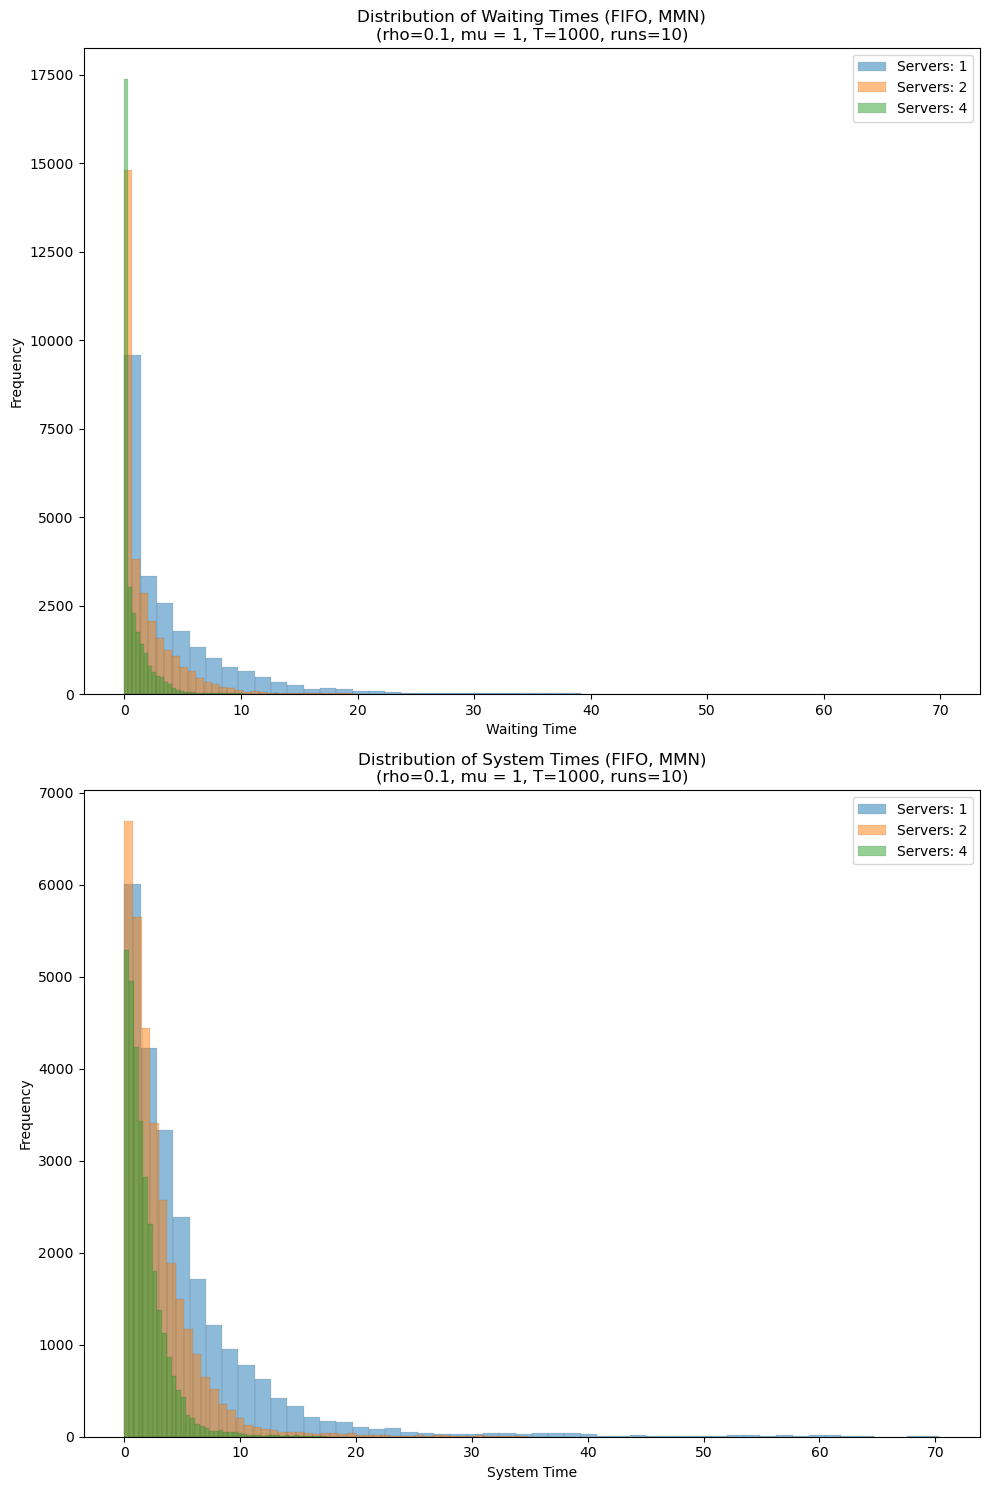

0.325
Average Waiting Times (FIFO, MMN): ['5.23', '2.38', '1.05']
Average System Times (FIFO, MMN): ['6.22', '3.37', '2.04']


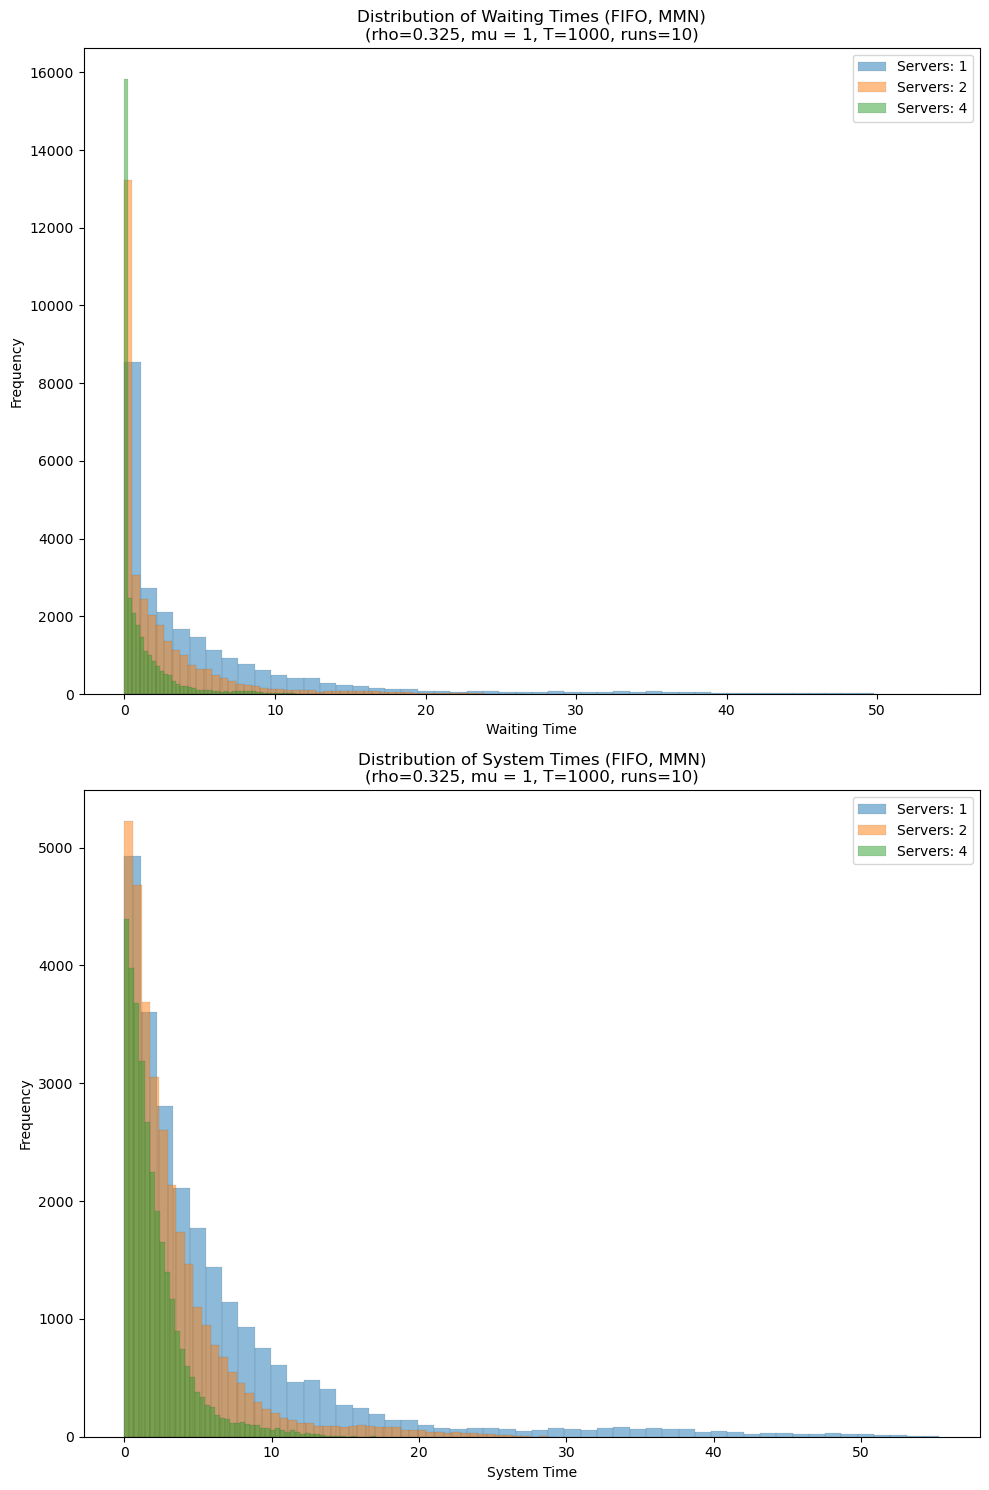

0.55
Average Waiting Times (FIFO, MMN): ['5.68', '2.69', '1.19']
Average System Times (FIFO, MMN): ['6.68', '3.68', '2.19']


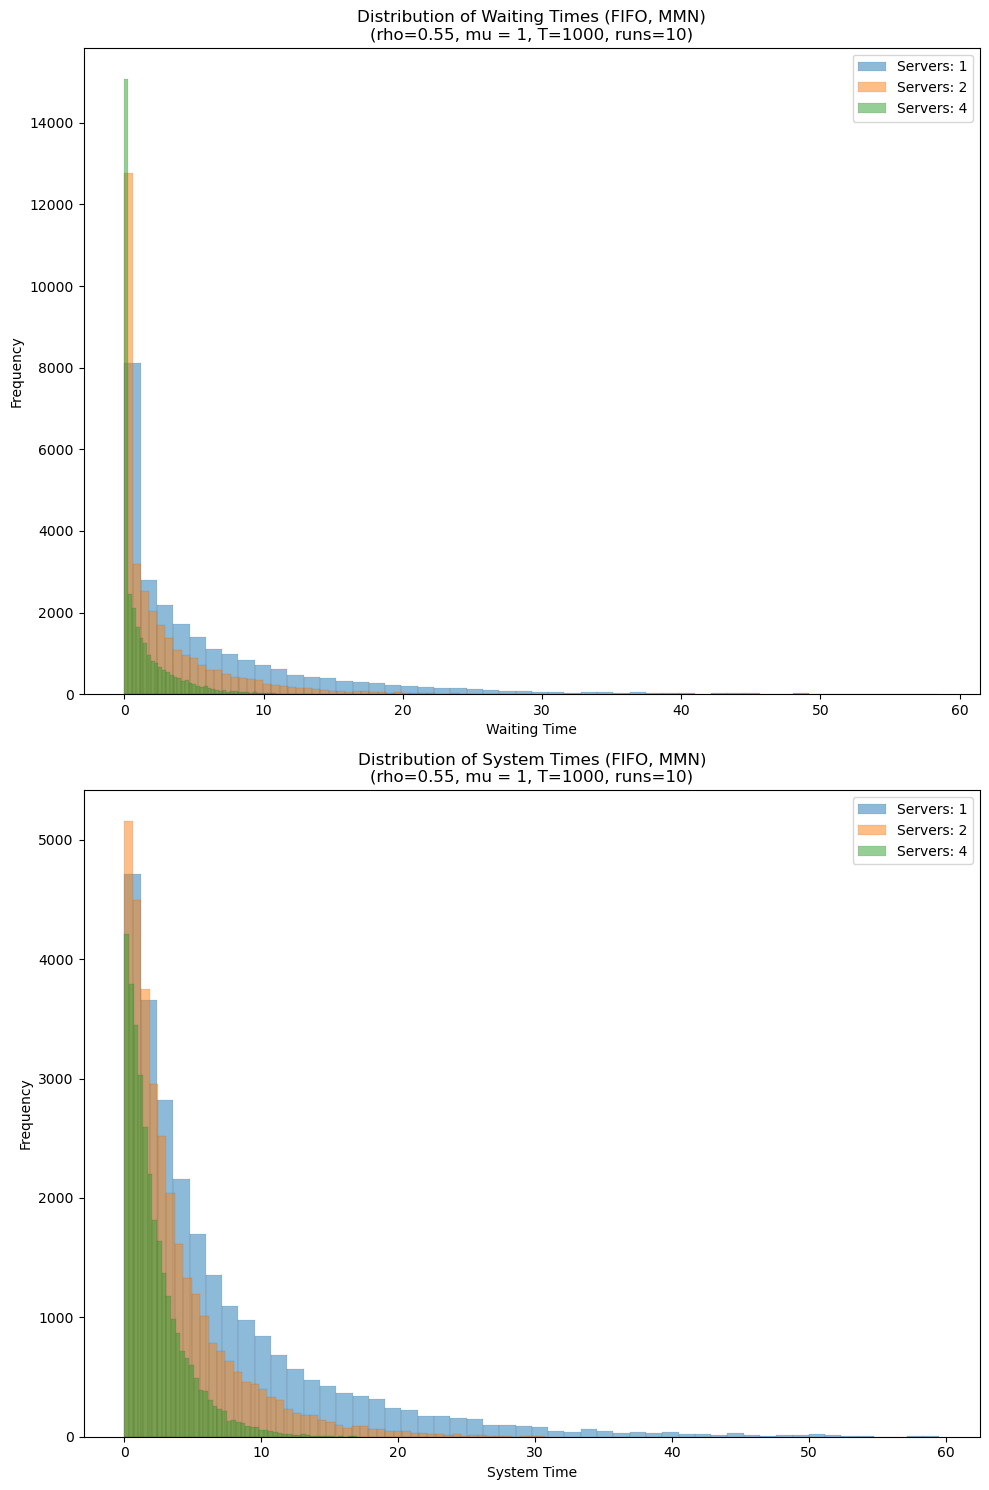

0.775


IndexError: index 3 is out of bounds for axis 0 with size 3

In [60]:
for i, rho in enumerate(rhos):
    print(rho)
    result = {}
    for key in results_FIFO:
        result[key] = results_SJF[key][i]
    plot_statistics(result, num_servers_arr, rho, mu, T, num_runs, edge_color='black')

In [58]:
plot_statistics(results_SJF, num_servers_arr, rho, mu, T, num_runs, edge_color='black', SJF=SJF)

TypeError: unsupported format string passed to numpy.ndarray.__format__

# Question 4

## MDN

In [ ]:
num_servers_arr = [1,2,4]
rho=0.9
mu=None
T=100
num_runs=5
SJF=True
deterministic_service_time=1

results_MDN = run_multiple_simulations(num_runs=num_runs, rho=rho, mu=mu, num_servers_arr=np.array(num_servers_arr), T=T, deterministic_service_time=deterministic_service_time)

In [ ]:
plot_statistics(results_MDN, num_servers_arr, rho, mu, T, num_runs, edge_color='black', deterministic_service_time=deterministic_service_time)

## Hyperexponential service time

Lambda here is calculated as self.lamb = rho * (num_servers_arr * (mus * probs).sum())

In [ ]:
num_servers_arr = [1,2,4]
rho=0.9
mu=None
T=1000
num_runs=5
SJF=True
hyperexp_service_time_params={
    'mus': [1, 5],
    'probs': [0.75, 0.25]
}

results_MDN = run_multiple_simulations(num_runs=num_runs, rho=rho, mu=mu, num_servers_arr=np.array(num_servers_arr), T=T, hyperexp_service_time_params=hyperexp_service_time_params)

In [ ]:
plot_statistics(results_MDN, num_servers_arr, rho, mu, T, num_runs, edge_color='black', hyperexp_service_time_params=hyperexp_service_time_params)